> Alon Arbel - 205730849

> Gev Keren - 315719906

In [181]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import math
%matplotlib inline

# Question 1 - Hough Transform

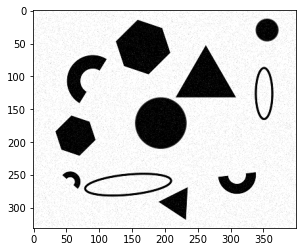

In [182]:
# Step 0: Read the image in grayscale
img = cv2.imread('semicircles-noisy-reducedSize.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

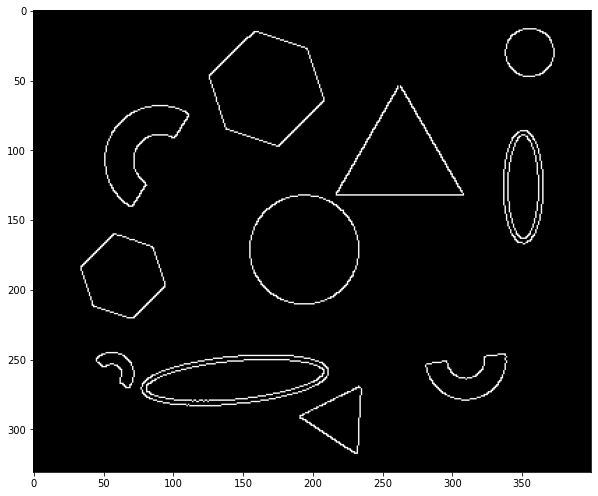

In [183]:
# represent the half circle in parametrized something
def edgeDetector(image, low_t):
  '''
  This function should get as input the grayscale 'image' and any additional
  parameters you need, and return 'edge_map': a binary image (same shape as 'image')
  with a value of 1 in each detected edge pixel and a value of zero otherwise.
  '''
  t1 = low_t
  t2 = 3 * low_t
  edge_map = cv2.Canny(image, threshold1=t1, threshold2=t2)
  for i in range(len(edge_map)):
    for j in range(len(edge_map[i])):
      if edge_map[i][j] != 0:
        edge_map[i][j] = 1
  # print(edge_map)
  return edge_map

# Step 1: Produce an edge map from the image using an edge detector
edges = edgeDetector(img, 360)
plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')


We decided to use Canny's edge detection algorithm because, as we saw in the previous assignment, it produces the best results, due to that canny's algorithm using a first derivation and therefore is less affected by noise.

Trying with kernels:

In [184]:
# kernel of a semi circle with a specific radius and angle
def kernel_constructor(r, theta, kernel_size):
  r = int(r)
  semi_circle_kernel = np.zeros((kernel_size, kernel_size))
  x = r
  y = r
  thetas = np.array([theta + i for i in range(180)])
  for theta in thetas:
    Center_x = round(x + r * np.cos(np.deg2rad(theta)))
    Center_y = round(y + r * np.sin(np.deg2rad(theta)))
    cond_x = Center_x < 2*r+1 and Center_x >=0
    cond_y = Center_y < 2*r+1 and Center_y>=0
    if(cond_x and cond_y):
      semi_circle_kernel[Center_x][Center_y] = 1
  return semi_circle_kernel


def hough_space_constructor(edge_map, min_r=2, min_theta=0):  
  radii = np.array([min_r + i for i in range(48)]) #48 radii between 2 and 50
  thetas = np.array([min_theta + 10*i for i in range(36)]) #15 degrees difference between each theta
  houghs = []
  for r in radii:
    for theta in thetas:
      kernel_size = r+r+1
      semi_circle_kernel = kernel_constructor(r, theta, kernel_size)
      votes = signal.convolve(edge_map, semi_circle_kernel, mode = "same")
      houghs.append((r, theta, votes))
  return houghs

def local_max_detector(houghs):
  accumulator = []
  for hough in houghs:
    # houghs = (r, theta, votes)
    r = hough[0]
    theta = hough[1]
    votes = hough[2]
    max_vote = np.max(votes)
    max = votes.argmax()
    shape = votes.shape
    max_vote_position = np.unravel_index(max, shape)
    if (2*r-1 <= max_vote and max_vote <= 2*r+1):
      accumulator.append((r, theta, max_vote, max_vote_position))
  accumulator = filter_less_votes(accumulator)
  return accumulator

def filter_less_votes(accumulator):
  votes = []
  for i in range(len(accumulator)):
    votes.append(accumulator[i][2])
  median = np.median(votes)
  filtered_accumulator = []
  for acc in accumulator:
    if acc[2] > median:
      filtered_accumulator.append(acc)
  return filtered_accumulator

In [185]:
hough_space = hough_space_constructor(edges)
detected_circles = local_max_detector(hough_space)

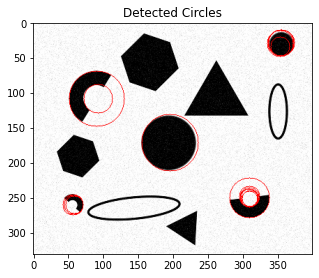

In [186]:
def plotSemiCircles(image):
  '''
  This function should plot the detected semicircles.
  It should draw the semicircles in red on top of the original grayscale image.
  You must add to this function parameters representing the detected semicircles 
  that should be drawn.
  '''
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  for r, _, _, position in detected_circles:
    r = int(r)
    cv2.circle(image,(position[1],position[0]),r,(255,0,0),1)
    
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(image, cmap="gray")
  ax.title.set_text("Detected Circles")
  
# Step 3: Plot the detected semicircles on top of the original image
plotSemiCircles(img)

In this section we tried to detect semicircles using convolutions with kernels we created.
1. We created semi circle shaped kernels
2. We created a hough space using convolution with the kernels
3. We detected the local maximum of each point and created an accumulator 4D array.
4. We filtered the points in the accumulator based on a threshhold which we chose to be the median of the votes for each circle.
5. plot circles

As seen, we managed to detect only circles and semi circles, and filtered all the irrelevant shapes (corners of shapes, hexagon, etc.)


# Question 3 - Segmentation and Relaxation Labeling

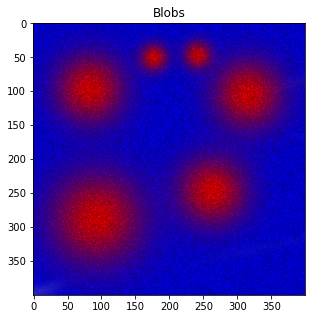

In [187]:
# Read the image in color (in RGB format)
blobs = cv2.imread('blobs.png') #reads color image in BGR format
blobs = cv2.cvtColor(blobs, cv2.COLOR_BGR2RGB) # converts the image to RGB format

# Plot the image
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.imshow(blobs)
ax.set_title("Blobs");

In [188]:
def set_initial_confidence(image,nLabels=2):
  '''
  Blue - Background, Label = 0
  Red - Circle, Label = 1
  '''
  rows, cols, RGB = image.shape
  initial_confidence = np.zeros((nLabels,rows, cols))
  for i in range(rows):
    for j in range(cols):
      if image[i][j][0] < image[i][j][2]: # BLUE
        initial_confidence[0][i][j] = 0.0001 # a value close to 0
        initial_confidence[1][i][j] = 1-0.0001 # a value close to 1
      else: # RED
        initial_confidence[0][i][j] = 1-0.0001 # a value close to 1
        initial_confidence[1][i][j] = 0.0001 # a value close to 0
  return initial_confidence

In [189]:
def update(curr_confidence, comp_kernel):
  nLabels, nRows, nColumns = curr_confidence.shape
  res = np.zeros_like(curr_confidence)
  res_denominator = np.zeros((nRows,nColumns))
  supp = support(comp_kernel,curr_confidence)
  for label in range(nLabels):
    res[label] = curr_confidence[label]*supp[label]
    res_denominator += res[label]
  res = res / res_denominator
  return res

In [190]:
def support(comp_kernel,confidence):
  '''
  This function is general now and returns the support for each pixel getting 
  each of the possible labels. E.g., supp[0] is a matrix same shape as our image,
  and the value in each of its cells represents the support for assigning label
  0 to the corresponding pixel in the image.
  '''
  nLabels, nRows, nColumns = confidence.shape
  supp = np.zeros_like(confidence)
  for label in range(nLabels):
    supp[label] = cv2.filter2D(confidence[label], ddepth=cv2.CV_64F, kernel=comp_kernel)
  return supp

In [191]:
# The average local consistency:
def average_local_consistency(confidence, comp_kernel):
    nLabels, nRows, nColumns = confidence.shape
    res_denominator = np.zeros((nRows,nColumns))
    supp = support(comp_kernel,confidence)
    for label in range(nLabels):
      res_denominator += confidence[label]*supp[label]
    alc = np.sum(res_denominator) #the average local consistency
    return alc

In [192]:
# Set the final assignment for each pixel as the label with the highest probability
def choose_label(confidence):
  nLabels, nRows, nColumns = confidence.shape
  segmentation_array = np.zeros((nRows, nColumns))
  for i in range(nRows):
    for j in range(nColumns):
      segmentation_array[i,j] = np.argmax(confidence[:,i,j])
  return segmentation_array

In [193]:

def gaussian_filter(n, sigma):
  kernel = np.zeros((n, n))
  center = n // 2
  for x in range(n):
    for y in range(n):
      r = math.sqrt((x - center)**2 + (y - center)**2)
      kernel[x, y] = (1 / (2 * math.pi * sigma**2)) * math.exp(-r**2 / (2 * sigma**2))
  kernel = kernel / kernel.sum()

  return kernel

In [194]:
def RelaxationLabeling(image, epsilon):
  '''
  This function should use relaxation labeling to correctly segment the input RGB image
  into 'object' and 'background' segments.
  It should get as input an image and any additional parameters needed for the
  computation.
  It should return as output a 'segmentation_array' which is 2D (has the same number of 
  rows and columns as the original image), and the value in each of its cells 
  represents the label of the corresponding pixel. The value represnting each label
  should be encoded by brightness level.
  Note: you may add any additional input and\or output parameters to this algorithm,
  but you must explain each of them in the atached pdf. 
  '''
  # Objects = pixels
  # Labels = [Background, Circles]
  image = cv2.cvtColor(blobs, cv2.COLOR_BGR2RGB) / 255
  curr_conf = set_initial_confidence(image) # This is P for iteration k=0
  k = 0 # counts the iteration number
  # Using a 41x41 gausian kernel
  comp_kernel = gaussian_filter(41, 8)
  while True:
    next_conf = update(curr_conf, comp_kernel)
    diff = abs(average_local_consistency(curr_conf, comp_kernel) - 
                 average_local_consistency(next_conf, comp_kernel))
    curr_conf = next_conf
    k = k + 1
    if diff < epsilon and k > 6:
      break
  print(f'Number of iterations = {k}')
  return choose_label(next_conf)

Number of iterations = 210


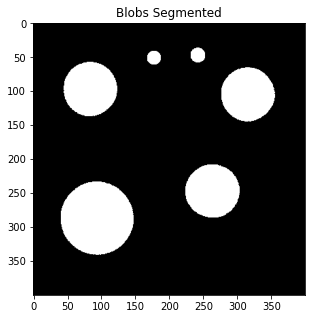

In [195]:
# Use your algorithm to segment the image
segmented_image = RelaxationLabeling(blobs, epsilon=2)

# Plots your result
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.imshow(segmented_image, cmap='gray')
ax.set_title("Blobs Segmented");